prep and load data

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn_pandas import DataFrameMapper

dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/iotid20.csv")
batch_size = 64
fe_data = dataset.copy()
fe_data = fe_data.drop(["Label", "Sub_Cat"], axis = 1)
le = preprocessing.LabelEncoder()
for column_name in fe_data.columns:
    if fe_data[column_name].dtype == object:
        fe_data[column_name] = le.fit_transform(fe_data[column_name])
    else:
        pass
fe_data.replace([np.inf, -np.inf], np.nan, inplace=True)
fe_data.dropna(inplace=True)
fe_datay = fe_data.Cat
fe_data = fe_data.drop(["Cat"], axis = 1)
scaler = StandardScaler()
mapper = DataFrameMapper([(fe_data.columns, StandardScaler())])
scaled_features = mapper.fit_transform(fe_data.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=fe_data.index, columns=fe_data.columns)
fe_datax = scaled_features_df
fex_train, fex_valid, fey_train, fey_valid = train_test_split(fe_datax, fe_datay, test_size = 0.3, random_state = 7)

In [3]:
fe_datax.head()

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
0,-0.736911,0.250293,-1.011778,-0.125878,-0.358338,1.307488,0.773641,-0.160332,-0.156791,-0.384331,...,-0.117722,0.0,-0.055323,-0.017058,-0.047788,-0.054019,-0.202409,-0.045456,-0.169801,-0.203131
1,-0.250776,1.113764,-1.328144,-0.187599,-0.902186,-0.737598,0.941439,1.336352,-0.156791,0.435478,...,-0.348456,0.0,-0.055323,-0.017058,-0.047788,-0.054019,1.018291,1.914911,1.287665,0.304516
2,-0.725363,0.250589,0.716565,-0.187599,-0.419918,-0.737598,-0.638660,-0.141462,-0.388745,1.255288,...,-0.348456,0.0,-0.055323,-0.017058,-0.047788,-0.054019,-0.204538,-0.044843,-0.171196,-0.205719
3,-0.724750,0.250589,0.726152,-0.187599,-0.419918,-0.737598,-1.928109,-0.138603,-0.388745,0.435478,...,-0.348456,0.0,-0.055323,-0.017058,-0.047788,-0.054019,-0.166450,-0.045456,-0.143295,-0.163803
4,-1.294735,0.250095,0.070808,2.219526,-0.825511,1.307488,-1.679408,-0.138031,0.075163,-0.384331,...,0.113012,0.0,-0.055323,-0.017058,-0.047788,-0.054019,-0.201699,-0.044843,-0.169103,-0.202614


In [ ]:
fe_datay.unique()

NameError: ignored

In [8]:
dl_train = pd.concat([fex_train, fey_train])
dl_test = pd.concat([fex_valid, fey_valid])
d_train = torch.tensor(dl_train.values, dtype=torch.float32)
d_test = torch.tensor(dl_test.values, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(d_train), batch_size = batch_size, shuffle = True)

define reusable metric func

In [4]:
def evaluate_multiclass_classification(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)

    # Calculate False Positive Rate (FPR) for each class
    # FPR = FP / (FP + TN)
    fpr = [cm[i, :].sum() - cm[i, i] / (cm[i, :].sum()) for i in range(len(cm))]

    # Calculate macro-averaged precision, recall, and FPR
    macro_precision = sum(precision) / len(precision)
    macro_recall = sum(recall) / len(recall)
    macro_fpr = sum(fpr) / len(fpr)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "FPR": fpr,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro FPR": macro_fpr
    }

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    # Extract the classes and their corresponding precision, recall, and accuracy
    classes = range(len(metrics['Precision']))
    precision = metrics['Precision']
    recall = metrics['Recall']
    accuracy = metrics['Accuracy']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot Precision
    axes[0].bar(classes, precision, tick_label=classes)
    axes[0].set_title('Precision')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Precision')

    # Plot Recall
    axes[1].bar(classes, recall, tick_label=classes)
    axes[1].set_title('Recall')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Recall')

    # Plot Accuracy
    axes[2].bar(['Accuracy'], [accuracy])
    axes[2].set_title('Accuracy')
    axes[2].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

AutoEncoder

In [5]:
import tensorflow as tf

input_dim = fex_train.shape[1]
input_layer = tf.keras.layers.Input(shape=(input_dim,))
hidden_layer = tf.keras.layers.Dense(40, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(hidden_layer)
autoencoder = tf.keras.models.Model(input_layer, output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(fex_train, fex_train, epochs=50, batch_size=32)

Epoch 1/50
13681/13681 [==============================] - 25s 2ms/step - loss: 0.6435
Epoch 2/50
13681/13681 [==============================] - 27s 2ms/step - loss: 0.6364
Epoch 3/50
13681/13681 [==============================] - 25s 2ms/step - loss: 0.6362
Epoch 4/50
13681/13681 [==============================] - 27s 2ms/step - loss: 0.6361
Epoch 5/50
13681/13681 [==============================] - 24s 2ms/step - loss: 0.6361
Epoch 6/50
13681/13681 [==============================] - 24s 2ms/step - loss: 0.6360
Epoch 7/50
13681/13681 [==============================] - 26s 2ms/step - loss: 0.6360
Epoch 8/50
13681/13681 [==============================] - 24s 2ms/step - loss: 0.6359
Epoch 9/50
13681/13681 [==============================] - 24s 2ms/step - loss: 0.6359
Epoch 10/50
13681/13681 [==============================] - 25s 2ms/step - loss: 0.6359
Epoch 11/50
13681/13681 [==============================] - 23s 2ms/step - loss: 0.6359
Epoch 12/50
13681/13681 [===========================

Validation

In [6]:
reconstructed_test_data = autoencoder.predict(fex_valid)
reconstruction_error = tf.reduce_mean(tf.square(fex_valid - reconstructed_test_data), axis=1)

5864/5864 [==============================] - 9s 1ms/step


In [7]:
predictions = reconstruction_error > 0.95
print(predictions)

tf.Tensor([False False False ... False False False], shape=(187625,), dtype=bool)


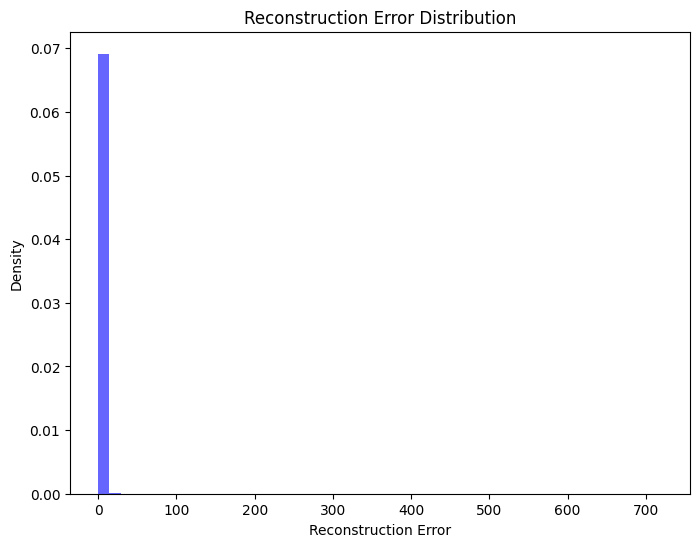

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(reconstruction_error, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution")
plt.show()

Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier as DT

class DecisionTree():
    model = any

    def create_model(self):
        self.model = DT(
            criterion = 'gini',
            splitter = 'best',
            max_depth = 100,
            min_samples_split = 2,
            min_samples_leaf = 1
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)

    def __init__(self) -> None:
        self.create_model()

trainset = [fex_train, fey_train]
dtm = DecisionTree()
dtm.train_model(trainset)

Validation

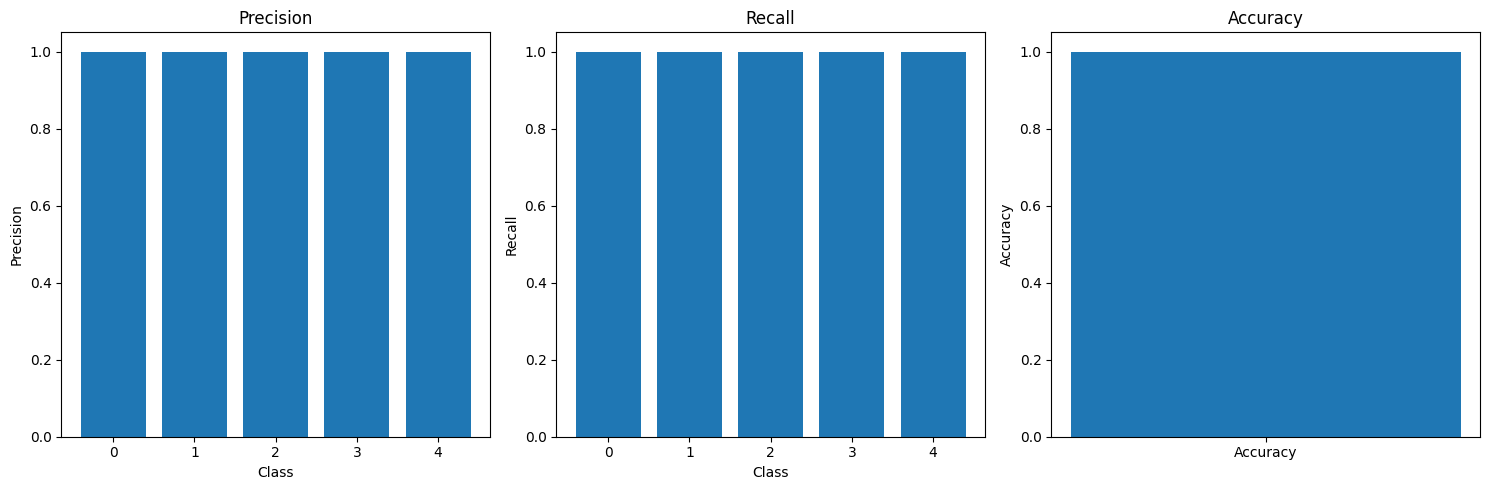

In [17]:
predictions = dtm.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

Gaussian NB

In [18]:
from sklearn.naive_bayes import GaussianNB as GNB

class GaussionNaiveBayes():
    model = any

    def create_model(self):
        self.model = GNB()

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)

    def __init__(self) -> None:
        self.create_model()

gnb = GaussionNaiveBayes()
gnb.train_model(trainset)

Validation

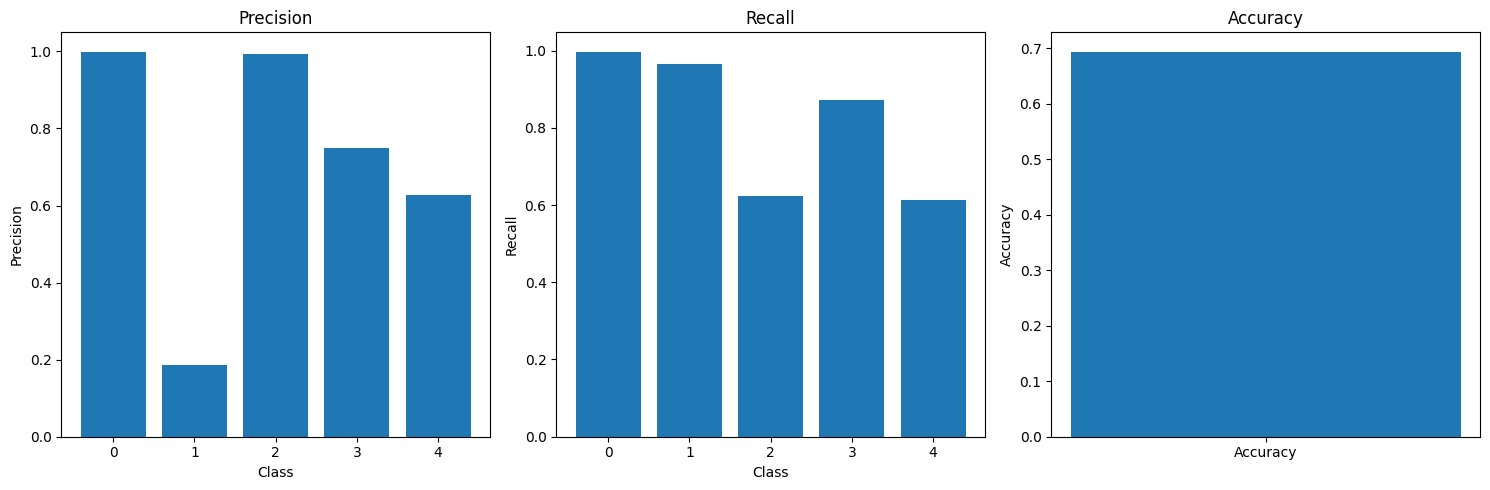

In [19]:
predictions = gnb.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

LDA

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

class LinearDiscriminantAnalysis():
    model = any

    def create_model(self):
        self.model = LDA(
            n_components = None,
            priors = None,
            shrinkage = None,
            solver = 'svd',
            store_covariance = False,
            tol = 0.0001
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)

    def __init__(self) -> None:
        self.create_model()

lda = LinearDiscriminantAnalysis()
lda.train_model(trainset)

Validation

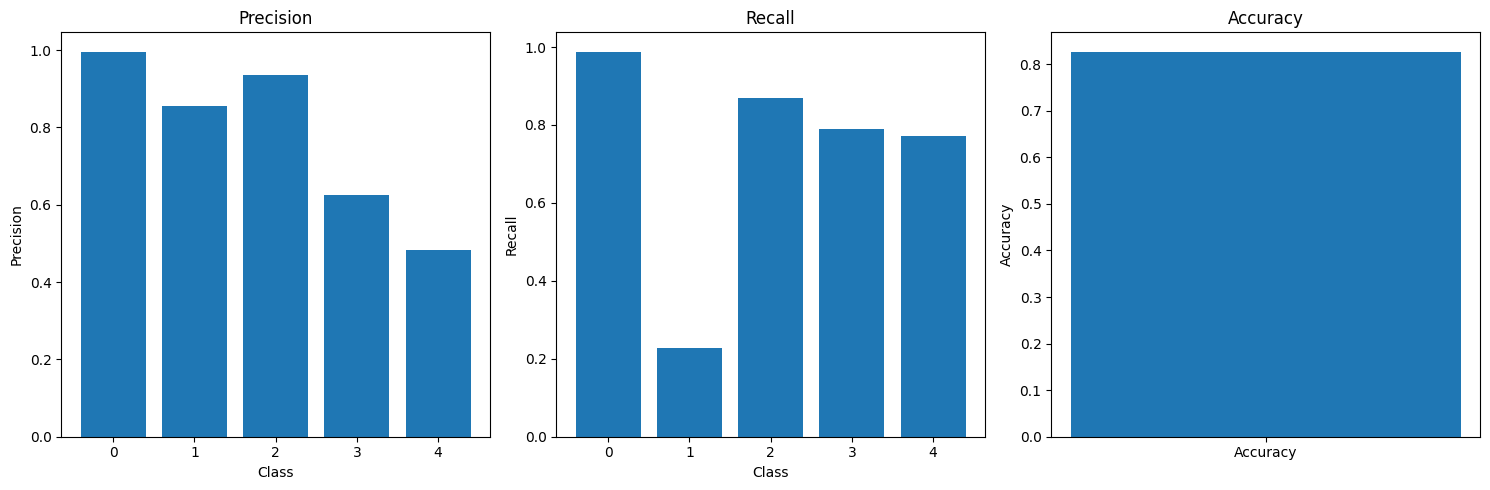

In [21]:
predictions = lda.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

LogReg

In [22]:
from sklearn.linear_model import LogisticRegression as LR

class LogisticRegression():
    model = any

    def create_model(self):
        self.model = LR(
            penalty = 'l2',
            dual = False,
            tol = 0.0001,
            C = 1.0,
            fit_intercept = True,
            intercept_scaling = 1,
            solver = 'sag',
            max_iter = 100,
            multi_class = 'ovr',
            verbose = 0,
            warm_start = False,
            l1_ratio = None
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)

    def __init__(self) -> None:
        self.create_model()

lr = LogisticRegression()
lr.train_model(trainset)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation

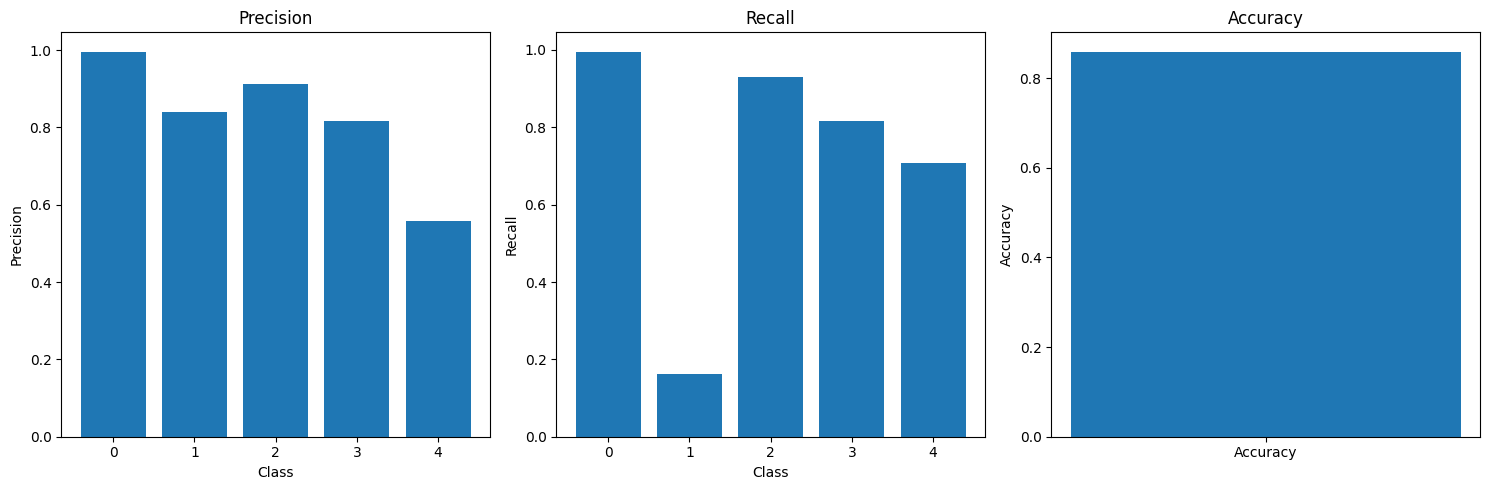

In [23]:
predictions = lr.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

RF

In [24]:
from sklearn.ensemble import RandomForestClassifier as RF

class RandomForest():
    model = any

    def create_model(self):
        self.model = RF(
            n_estimators = 10,
            criterion = 'gini',
            max_depth = 100
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)

    def __init__(self) -> None:
        self.create_model()

rf = RandomForest()
rf.train_model(trainset)

Validation

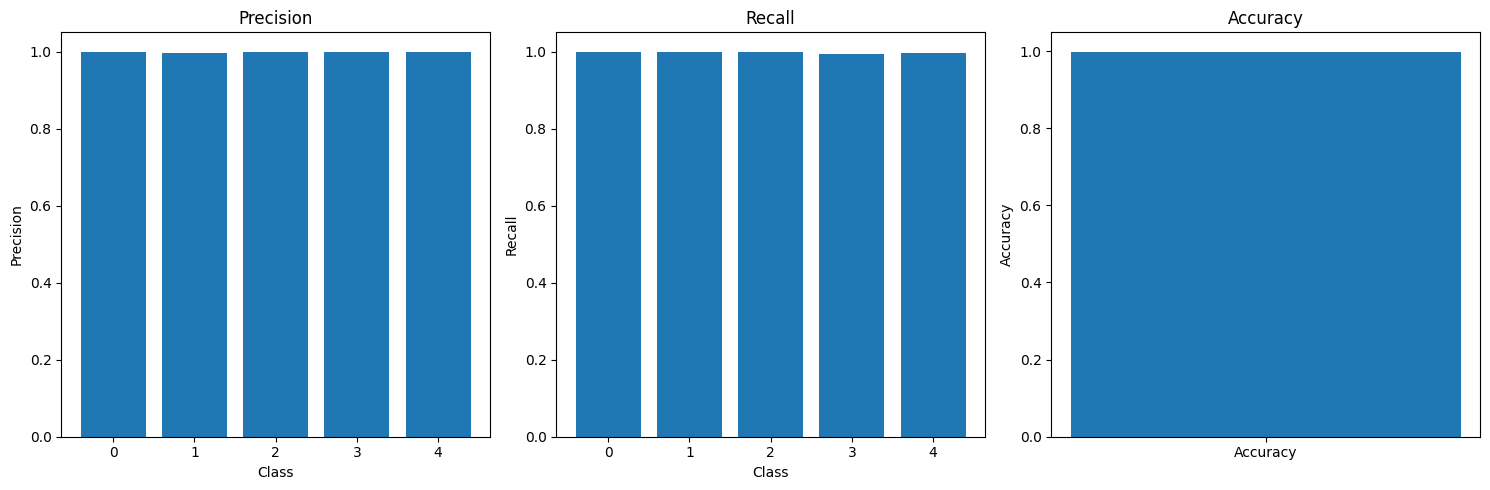

In [25]:
predictions = rf.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

SVM

In [ ]:
from sklearn.svm import SVC

class SupportVectorMachine():
    model = any

    def create_model(self):
        self.model = SVC(
            C = 1,
            kernel = 'linear',
            decision_function_shape = 'ovr',
            max_iter = 1000
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)

    def __init__(self) -> None:
        self.create_model()

svm = SupportVectorMachine()
svm.train_model(trainset)

Validation

In [ ]:
predictions = svm.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))